In [ ]:
import csv
import tensorflow as tf
import numpy as np
import urllib
import pandas as pd
import matplotlib.pyplot as plt
! pip install -q kaggle
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d roopahegde/cryptocurrency-timeseries-2020
! unzip \*.zip  && rm *.zip

 40% 9.00M/22.7M [00:00<00:00, 91.4MB/s]
100% 22.7M/22.7M [00:00<00:00, 111MB/s] 
Archive:  cryptocurrency-timeseries-2020.zip
  inflating: gemini_BTCUSD_2020_1min.csv  
  inflating: gemini_ETHUSD_2020_1min.csv  
  inflating: gemini_LTCUSD_2020_1min.csv  


In [3]:
data = pd.read_csv('/content/gemini_BTCUSD_2020_1min.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658065 entries, 0 to 658064
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unix Timestamp  658065 non-null  float64
 1   Date            658065 non-null  object 
 2   Symbol          658065 non-null  object 
 3   Open            658065 non-null  float64
 4   High            658065 non-null  float64
 5   Low             658065 non-null  float64
 6   Close           658065 non-null  float64
 7   Volume          658065 non-null  float64
dtypes: float64(6), object(2)
memory usage: 40.2+ MB


In [4]:
# cek 5 data teratas
data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.618880e+12,4/20/2021 0:02,BTCUSD,55717.47,55723.00,55541.69,55541.69,2.406734
1,1.618880e+12,4/20/2021 0:01,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.573458
2,1.618880e+12,4/20/2021 0:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.309904
3,1.618880e+12,4/19/2021 23:59,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.684934
4,1.618880e+12,4/19/2021 23:58,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.477225


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

open = data['Open'].values
time_step = [i for i in range(len(open))]
series = np.array(open)

# Normalisasi data
min = np.min(series)
max = np.max(series)
series -= min
series /= max
time = np.array(time_step)

# Pembagian untuk spitting data
split_time = int(len(open)*0.8)

# Split data
time_train = time[:split_time] 
x_train = series[:split_time]
time_valid = time[split_time:] 
x_valid = series[split_time:]

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
val_set = windowed_dataset(x_valid, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
print(x_train.shape, x_valid.shape)

(526452,) (131613,)


In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae')<0.2 and logs.get('val_mae')<0.2:
            print('MAE & Val_MAE sudah < 0.2 ...')
            self.model.stop_training = True

model = tf.keras.models.Sequential([    
            tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                            strides=1, padding='causal',
                            activation='relu',
                            input_shape=[None, 1]),
            tf.keras.layers.MaxPooling1D(3),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1)
    ], name='SCB-LSTM')

model.summary()

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
            optimizer=optimizer,
            metrics=['mae'])

Model: "SCB-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 128)         768       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 42,645
Trainable params: 42,645
Non-trainable params: 0
______________________________________________________

In [8]:
history = model.fit(train_set, 
                    validation_data=val_set,
                    epochs=25, 
                    callbacks=[myCallback()],
                    )

Epoch 1/25
2057/2057 [==============================] - 278s 133ms/step - loss: 0.0661 - mae: 0.2148 - val_loss: 7.2780e-04 - val_mae: 0.0332
Epoch 2/25
2057/2057 [==============================] - 270s 131ms/step - loss: 0.0355 - mae: 0.1804 - val_loss: 0.0037 - val_mae: 0.0845
MAE & Val_MAE sudah < 0.2 ...


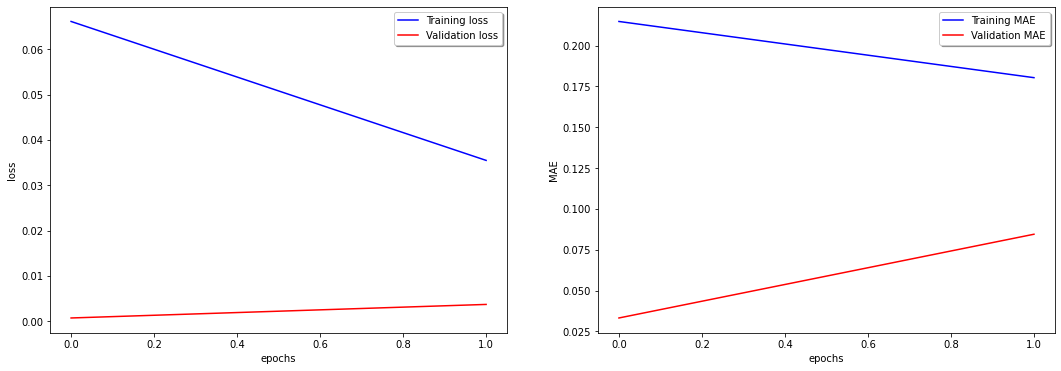

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')    
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['mae'], color='b', label='Training MAE')
axs[1].plot(history.history['val_mae'], color='r', label='Validation MAE')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('MAE')
axs[1].legend(loc='best', shadow=True)